In [1]:
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import yfinance as yf
import sklearn as sk
from sklearn import gaussian_process as gp
from sklearn.gaussian_process.kernels import DotProduct, RBF, WhiteKernel


# Plot the results


In [2]:
def trailing_avg(arr):
    return sum(arr)/len(arr)

In [ ]:
start_date = '2021-01-01'
end_date = '2025-03-31'
index = 'AAPL'  # Example stock symbol, change as needed
# Get the stock data
stock = yf.download(index, start=start_date, end=end_date)

data = pd.DataFrame.to_numpy(stock['Close'])
data = data-data[0]
days = np.atleast_2d(np.arange(len(data))).T

# Downsample the data, -2 to ensure there is unsampled data for prediction
sparse_data = [trailing_avg(data[10*(i-1):10*i]) for i in range(1,len(data)//10-4)]  
sparse_days = np.atleast_2d(np.arange(len(sparse_data))*10).T

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
# Create the Gaussian Process model
kernel = 0.3*DotProduct()+0.3*RBF(length_scale=1e-2)  + 0.1*WhiteKernel(
    noise_level=1e-2, noise_level_bounds=(1e-10, 1e1))
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100)

# Fit the model to the data
model.fit(sparse_days, sparse_data)

# Make predictions
predictions = model.predict(days, return_std=True)

# Get the dates for the x-axis
dates = pd.date_range(start=start_date, end=end_date)

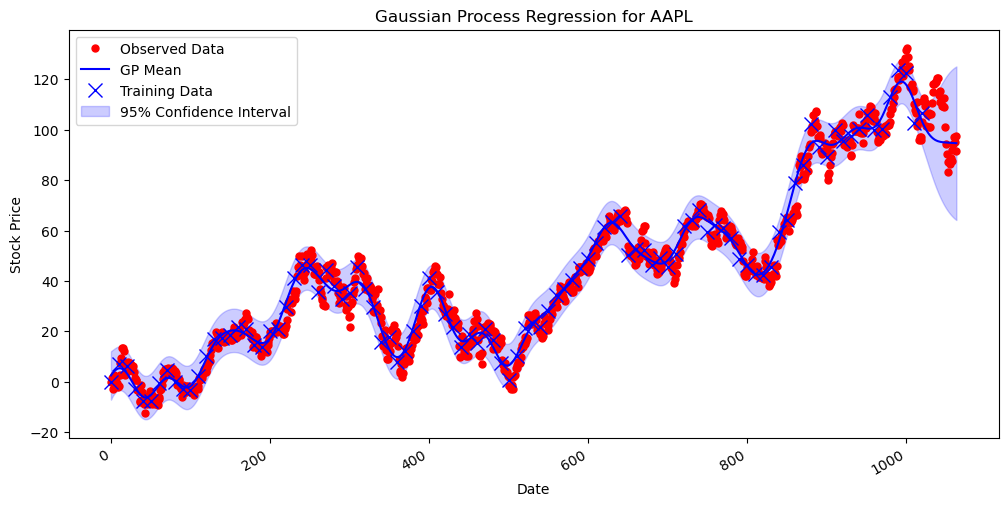

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(days, data, 'r.', markersize=10, label='Observed Data')
plt.plot(days, predictions[0], 'b-', label='GP Mean')
plt.plot(sparse_days, sparse_data, 'bx', markersize=10, label='Training Data')
plt.fill_between(np.arange(len(data)), predictions[0] - 1.96 * predictions[1], predictions[0] + 1.96 * predictions[1], alpha=0.2, color='blue', label='95% Confidence Interval')
plt.title(f'Gaussian Process Regression for {index}')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate() 
plt.show()